In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [15]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [16]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 200.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    #P_v = par.P_v,                    # vapour pressure [Pa]
    #mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-x * par.atm2Pa for x in [3.0, 1.0]], # [atm --> Pa]
    logf = [4.0, 5.0],
    n = [1.0],
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

In [11]:
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 50    # number os total searches

kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=gd.rand_point(ranges, padding=0.1),
    step_limit=200,
    first_step=0.05, #between two parameter combinations
    min_step=1e-4, #between two parameter combinations
    decay=0.6,
    delta=1e-5,
    log10=True,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for i in range(searches)]

In [18]:
"""Save settings as txt"""

# create folder for parameter study results:
file = gd.de.Make_dir('2_plus_1_gradient_search/1_atm_gd_smaller_intervals_logf')

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

Folder already exists with 0 csv in it


In [19]:
""" Gradient method, multithread"""

best_output = 1.0e30
total_point_num = 0
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        all_datas, best_outputs, elapsed = result
        point_num = sum([len(datas) for datas in all_datas])
        total_point_num += point_num
        num += 1
        to_plot.append(best_outputs)
        if len(all_datas) > 0 and len(all_datas[-1]) > 0:
            last_points.append(gd.de.copy(all_datas[-1][0]))
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]

        # save points
        file.new_file()
        for datas in all_datas:
            for data in datas:
                file.write_line(data)
        file.close()
        del(all_datas)
        
        # print stuff:
        if point_num==0: point_num=1
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps and {point_num: <4} points, finished in {elapsed: 8.2f} [s]   ({(elapsed / point_num): 4.2f} [s/run]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5611309195412D-04   r2 =  0.2923789298252D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5611309195412D-04   r2 =  0.2923789298252D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5611309195412D-04   r2 =  0.2923789298252D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5611309195412D-04   r2 =  0.2300739559913D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2823308468377D+00   r2 =  0.9001099491444D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2709954750298D-04   r2 =  0.1508669049084D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2709954750298D-04   r2 =  0.1508669049084D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2709954750298D-04   r2 =  0.1508669049084D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 6.67478872603823e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -220211.09484857158, 'logf': 4.788414405249068, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2823308468377D+00   r2 =  0.9001099491444D-07
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 6.67478872603823e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -220211.09484857158, 'logf': 4.806414405249067, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2179774754099D+00   r2 =  0.5474896307733D-07
	Warning, forward point failed, trial_num=1; forward_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 6.424428853648185e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -221103.89174931045, 'logf': 4.820008795080112, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 6.388988981258139e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -221996.68865004933, 'logf': 4.815603184911156, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.000814

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3079493560477D+00   r2 =  0.1262136967572D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6167823535301D+00   r2 =  0.4979223248485D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Error, central point failed
  3/50: Total 14  steps and 78   points, finished in   318.77 [s]   ( 4.09 [s/run]).   Final energy_efficiency:     26.2 (best:   26.2)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1290267079563D+00   r2 =  0.1359048511955D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1290267079563D+00   r2 =  0.1359048511955D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3371385772206D+00   r2 =  0.1414245254917D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7007197091281D+00   r2 =  0.4963334574900D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7007197091281D+00   r2 =  0.4963334574900D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7007197091281D+00   r2 =  0.4963334574900D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2018740830593D+00   r2 =  0.8971055222319D-07
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 5.5600973777395493e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -189714.35333636054, 'logf': 4.730997144058595, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Error, central point failed
  4/50: Total 17  steps and 91   points, finished in   207.66 [s]   ( 2.28 [s/run]).   Final energy_efficiency:     25.6 (best:   25.6)
	Error, central point failed


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8479371476487D+00   r2 =                  NaN
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 5.5600973777395493e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -189714.35333636054, 'logf': 4.7374771440585945, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3927900141899D+00   r2 =  0.3589721999665D-07
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 5.5600973777395493e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -189714.353

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4962278510347D+00   r2 =  0.1555999692140D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3193405544073D+00   r2 =  0.1174658728761D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2118395703471D-04   r2 =  0.1488368235472D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2118395703471D-04   r2 =  0.1488368235472D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3384698897577D+00   r2 =  0.2830074793403D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9135064529063D+00   r2 =  0.1673638028534D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4056675474703D+00   r2 =  0.2189095054055D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3384698897577D+00   r2 =  0.2830074793403D-07
	Error, central point failed
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2118395703471D-04   r2 =  0.1488368235472D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2118395703471D-04   r2 =  0.1488368235472D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       su

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6945972930258D+00   r2 =  0.5323437948786D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6945972930258D+00   r2 =  0.5323437948786D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6945972930258D+00   r2 =  0.5323437948786D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6945972930258D+00   r2 =  0.5323437948786D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  6/50: Total 15  steps and 77   points, finished in   174.26 [s]   ( 2.26 [s/run]).   Final energy_efficiency:     24.7 (best:    3.0)
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 8.762337738946253e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212149.82061333087, 'logf': 4.694275316655828, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
  7/50: Total 1   steps and 1    points, finished in    14.69 [s]   ( 14.69 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:    3.0)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5303175232119D+00   r2 =  0.1492956970685D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       correc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; forward_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4327669873688D-04   r2 =  0.3330272588899D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4327669873688D-04   r2 =  0.3330272588899D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4327669873688D-04   r2 =  0.3330272588899D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3160630780085D-03   r2 =  0.2602051654483D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3160630780085D-03   r2 =  0.2602051654483D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3160630780085D-03   r2 =  0.2602051654483D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3160630780085D-03   r2 =  0.2036414443445D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5908932883563D+00   r2 =  0.1952711252983D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1867598040919D+00   r2 =  0.7540126548540D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8420548969761D+00   r2 =  0.4317006812777D-06
 12/50: Total 18  steps and 90   points, finished in   105.65 [s]   ( 1.17 [s/run]).   Final energy_efficiency:     24.2 (best:    3.0)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9236772294224D+00   r2 =  0.2911482642272D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5877508579478D+00   r2 =  0.4996578552121D-16
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5877508579522D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6650686153092D+00   r2 =  0.2695844211554D-06
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5876002500311D-04   r2 =  0.2850709247838D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
     

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 14/50: Total 31  steps and 157  points, finished in   885.38 [s]   ( 5.64 [s/run]).   Final energy_efficiency:      3.0 (best:    3.0)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4633587127908D-04   r2 =  0.2807251830681D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4633587127908D-04   r2 =  0.2807251830681D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4633587127908D-04   r2 =  0.2807251830681D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8084522011270D+00   r2 =  0.2237725271617D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04   r2 =  0.2927475641180D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04   r2 =  0.2927475641180D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04   r2 =  0.2927475641180D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 16/50: Total 14  steps and 72   points, finished in   204.80 [s]   ( 2.84 [s/run]).   Final energy_efficiency:     26.7 (best:    3.0)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3454106398875D+00   r2 =  0.2354561402944D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3454106398875D+00   r2 =  0.2354561402944D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3454106398875D+00   r2 =  0.2354561402944D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6149633466282D+00   r2 =  0.5330713680872D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6149633466282D+00   r2 =  0.5330713680872D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6149633466282D+00   r2 =  0.5330713680872D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6149633466282D+00   r2 =  0.5330713680872D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028955440861D-04   r2 =  0.2672245201993D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028955440861D-04   r2 =  0.2672245201993D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028955440861D-04   r2 =  0.2672245201993D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028955440861D-04   r2 =  0.2060657380205D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794406947172D+00   r2 =  0.2414364609052D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794406947172D+00   r2 =  0.2414364609052D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794406947172D+00   r2 =  0.2414364609052D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794406947172D+00   r2 =  0.2414364609052D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 17/50: Total 14  steps and 74   points, finished in   307.07 [s]   ( 4.15 [s/run]).   Final energy_efficiency:     26.0 (best:    3.0)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6045065368399D-04   r2 =  0.2650802136287D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6045065368399D-04   r2 =  0.2650802136287D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6045065368399D-04   r2 =  0.2650802136287D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 8.812643191078448e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -264089.88845410326, 'logf': 4.873177164178657, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 18/50: Total 1   steps and 1    points, finished in    12.01 [s]   ( 12.01 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:    3.0)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817193900823D-04   r2 =  0.2769584288722D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817193900823D-04   r2 =  0.2769584288722D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817193900823D-04   r2 =  0.2769584288722D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4817193900823D-04   r2 =  0.2178385271443D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04   r2 =  0.2927475641180D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04   r2 =  0.2927475641180D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04   r2 =  0.2927475641180D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5878588143609D-04

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.0001276907441917049, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -124799.86701365607, 'logf': 4.4338529165823575, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1662091669498D+00   r2 =  0.1310366254610D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1662091669498D+00   r2 =  0.1310366254610D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue an

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6333207227173D-04   r2 =  0.6649493017577D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6333207227173D-04   r2 =  0.6649493017577D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6333207227173D-04   r2 =  0.6649493017577D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6333207227173D-04   r2 =  0.5239525577625D-20
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8659814711103D+00   r2 =  0.5815727882189D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4540753932939D+00   r2 =  0.4237430959143D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 19/50: Total 15  steps and 75   points, finished in   204.08 [s]   ( 2.72 [s/run]).   Final energy_efficiency:     25.6 (best:    3.0)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4368373029345D+00   r2 =  0.4458502856778D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028955440861D-04   r2 =  0.2672245201993D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028955440861D-04   r2 =  0.2672245201993D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3543567550314D+00   r2 =                  NaN
	Error, central point failed
	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9452057607996D+00   r2 =  0.2090234344498D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4040222746523D+00   r2 =  0.2310750606305D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4040222746523D+00   r2 =  0.2310750606305D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4040222746523D+00   r2 =  0.2310750606305D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4040222746523D+00

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2968708341409D+00   r2 =  0.8505088951006D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7252582813458D+00   r2 =  0.8825133216511D-08


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3054743093797D+00   r2 =  0.3407726443412D-08
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6510139828777D-04   r2 =  0.6342126176241D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6510139828777D-04   r2 =  0.6342126176241D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6510139828777D-04   r2 =  0.6342126176241D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6514150291467D+00   r2 =  0.4896707190129D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6514150291467D+00   r2 =  0.4896707190129D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6514150291467D+00   r2 =  0.4896707190129D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6514150291467D+00   r2 =  0.4896707190129D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1671259379325D-04   r2 =  0.1600913732366D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1671259379325D-04   r2 =  0.1600913732366D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1671259379325D-04   r2 =  0.1600913732366D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1671259379325D-04   r2 =  0.1232036133693D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3508183063122D+00   r2 =  0.1386567905842D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3727993393645D+00   r2 =  0.1580955093420D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1695608504878D-04   r2 =  0.1585338994271D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1695608504878D-04   r2 =  0.1585338994271D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3489176202075D+00   r2 =  0.1725094685455D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4181958115516D+00   r2 =  0.2705962400773D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4181958115516D+00   r2 =  0.2705962400773D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4181958115516D+00   r2 =  0.2705962400773D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3083337874254D+00   r2 =  0.2635028157107D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3083337874254D+00   r2 =  0.2635028157107D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3083337874254D+00   r2 =  0.2635028157107D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3083337874254D+00   r2 =  0.2635028157107D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2701656429787D+00   r2 =  0.7736166521013D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4181958115516D+00   r2 =  0.2705962400773D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4181958115516D+00   r2 =  0.2705962400773D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4181958115516D+00   r2 =  0.2705962400773D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, backward point failed, trial_num=1; backward_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4530594980156D+00   r2 =  0.2005751429926D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5931385404807D+00   r2 =  0.4907256684069D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5931385404807D+00   r2 =  0.4907256684069D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5931385404807D+00   r2 =  0.4907256684069D-16
 lsoda--  warning..internal t (=r1)

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7731180663992D-01   r2 =  0.6513146412662D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7731180663992D-01   r2 =  0.6513146412662D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7731180663992D-01   r2 =  0.6513146412662D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7731180663992D-01   r2 =  0.6513146412662D-17
 lsoda-

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7114613609672D+00   r2 =  0.8490822200335D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4145337534843D+00   r2 =  0.1710733463623D-06
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.000152796547513267, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -226387.1232430759, 'logf': 4.384697010402688, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=2; current_delta=2e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.000152796547513267, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -226387.1232430759, 'logf': 4.380809010402688, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2742101270653D+00   r2 =  0.8375687419512D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2895643652932D+00   r2 =  0.8722996660888D-07
 22/50: Total 35  steps and 204  points, finished in  1371.27 [s]   ( 6.72 [s/run]).   Final energy_efficiency:      2.9 (best:    2.9)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1345701735005D+00   r2 =  0.1249733245675D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1520631016290D+00   r2 =  0.1287950881841D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1520631016290D+00   r2 =  0.1287950881841D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1520631016290D+00   r2 =  0.1287950881841D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1520631016290D+00   r2 =  0.1287950881841D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 3.5198090251320425e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -145840.98036603967, 'logf': 4.88907340838105, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9682430229372D+00   r2 =  0.2422865071317D-08


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9423780082979D+00   r2 =  0.3290865688995D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9423780082979D+00   r2 =  0.3290865688995D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9423780082979D+00   r2 =  0.3290865688995D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9423780082979D+00   r2 =  0.3290865688995D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7680397659934D+00   r2 =                  NaN
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 3.777713025132043e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -146786.46420603967, 'logf': 4.8929614083810495, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Error, central point failed
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4712149132676D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7285096939674D+00   r2 =

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7944832314498D+00   r2 =  0.2997317828535D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 3.779219537854743e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -147559.4802300761, 'logf': 4.891576491468161, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; forward_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4165802630150D+00   r2 =  0.2296331441247D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4165802630150D+0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7889598985937D+00   r2 =  0.2317748501879D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 3.784807506874468e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -147596.49484530344, 'logf': 4.891355615017882, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 24/50: Total 31  steps and 163  points, finished in   922.16 [s]   ( 5.66 [s/run]).   Final energy_efficiency:      3.1 (best:    2.9)
	Error, central point failed
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2955026413260D+00   r2 =  0.2541485683940D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
     

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3479983255863D+00   r2 =  0.9045099820106D-07
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.0001757840941062838, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -186658.42129891357, 'logf': 4.61909279837541, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2271557289248D+00   r2 =  0.9577513771914D-07
 26/50: Total 30  steps and 154  points, finished in   774.69 [s]   ( 5.03 [s/run]).   Final energy_efficiency:      3.0 (best:    2.9)
 27/50: Total 26  steps and 143  points, finished in  1014.78 [s]   ( 7.10 [s/run]).   Final energy_efficiency:      3.0 (best:    2.9)


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4793393456817D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2271557289248D+00   r2 =  0.9577513771914D-07
	Error, central point failed
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00017787633325544084, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -135892.4406531261, 'logf': 4.142324574282216, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above, 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7379197243178D+00   r2 =  0.4866149729133D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7379197243178D+00   r2 =  0.4866149729133D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7379197243178D+00   r2 =  0.4866149729133D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7379197243178D+00   r2 =  0.4866149729133D-16
 lsoda--  at t (=r1), too much accur

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6364345708390D+00   r2 =  0.5111575179020D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2253329447204D+00   r2 =  0.1367675448750D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2253329447204D+00   r2 =  0.1367675448750D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2253329447204D+00   r2 =  0.1367675448750D-16

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 8.120474675828285e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -186965.80641941403, 'logf': 4.792617338707351, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5697240563347D+00   r2 =  0.9921487784609D-08
	Warning, forward point failed, trial_num=2; current_delta=2e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4975122589868D+00   r2 =  0.9623910917730D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2111750851419D+00   r2 =  0.7524743708014D-07
	Warning, forward point failed, trial_num=1; forward_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00018031402301499643, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -276624.2620231837, 'logf': 4.87869527600206, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4076598953215D+00   r2 =  0.5499154696971D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h =

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 32/50: Total 14  steps and 76   points, finished in   123.79 [s]   ( 1.63 [s/run]).   Final energy_efficiency:     25.7 (best:    2.9)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5069949562825D+00   r2 =  0.5139099091597D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5069949562825D+00   r2 =  0.5139099091597D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5069949562825D+00   r2 =  0.5139099091597D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4606029049064D+00   r2 =  0.5665652105783D-08


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
	Warning, forward point failed, trial_num=3; current_delta=4e-05
	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7661189061898D-01   r2 =  0.3543786898430D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4048446272900D+00   r2 =  0.1402249202938D-06
	Warning, forward point failed, trial_num=1; forward_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7661189061898D-01   r2 =  0.3543786898430D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.497158

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2826963380985D+00   r2 =  0.1079572904944D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1874710498406D+00   r2 =  0.1307358044056D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1874710498406D+00   r2 =  0.1307358044056D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1874710498406D+00   r2 =  0.1307358044056D-

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05	Warning, forward point failed, trial_num=1; current_delta=1e-05

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3099092672725D+00   r2 =  0.2755001722240D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3099092672725D+00   r2 =  0.2755001722240D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3099092672725D+00   r2 =  0.2755001722240D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2869509533194D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8060039560774D-01   r2 =  0.3778692309802D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8908601852773D+00   r2 =  0.8226158654263D-08


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2869509533194D+00   r2 =                  NaN
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2817960698521D+00   r2 =  0.2330040276228D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2817960698521D+00   r2 =  0.2330040276228D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2817960698521D

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; forward_delta=1e-05
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3765765685736D+00   r2 =                  NaN
 34/50: Total 32  steps and 163  points, finished in   722.65 [s]   ( 4.43 [s/run]).   Final energy_efficiency:      3.1 (best:    2.9)
	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2262765489705D+00   r2 =  0.9244936943501D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7183989356212D+00   r2 =  0.5265299144584D-08
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyw

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3628324082155D+00   r2 =  0.3341174516849D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1325200566274D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3628324082155D+00   r2 =  0.3341174516849D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1248677024388D+00   r2 =  0.6233117702102D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1248677024388D+00   r2 =  0.6233117702102D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9991768807039D+00   r2 =  0.4946069724166D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9991768807039D+00   r2 =  0.4946069724166D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9991768807039D+00   r2 =  0.4946069724166D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9991768807039D+00   r2 =  0.4946069724166D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, backward point failed, trial_num=2; backward_delta=2e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2243229580170D+00   r2 =  0.6789322236195D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6554381415169D+00   r2 =  0.1907838997096D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2410766328073D+00   r2 =  0.1219414240023D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2410766328073D+00   r2 =  0.1219414240023D-16
 lsoda--  warning..intern

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
	Error, central point failed
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6471323537444D+00   r2 =  0.6032768919068D-07
	Error, central point failed
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1715798595500D+00   r2 =  0.1165001131411D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1715798595500D+00   r2 =  0.1165001131411D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine,

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5938599877730D-01   r2 =  0.2947653285040D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5938599877730D-01   r2 =  0.2947653285040D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5938599877730D-01   r2 =  0.2947653285040D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5938599877730D-01   r2 =  0.2947653285040D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5688973475657D+00   r2 =  0.1287798300157D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7104478905886D+00   r2 =  0.5611264506763D-08
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6067721166497D+00   r2 =                  NaN
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00014155891046691867, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -142999.5573536204, 'logf': 4.586966029819697, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L':

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Error, central point failed
 38/50: Total 14  steps and 74   points, finished in   113.87 [s]   ( 1.54 [s/run]).   Final energy_efficiency:     26.2 (best:    2.9)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3186709189341D+00   r2 =  0.2255771686666D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3186709189341D+00   r2 =  0.2255771686666D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3186709189341D+00   r2 =  0.2255771686666D-16
 lsoda--  warning..internal t (=r1) and h (=r2)

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; forward_delta=1e-05
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3848922786601D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3590085959844D+00   r2 =  0.3002245673155D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2332535492011D-04   r2 =  0.1443467448630D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2332535492011D-04   r2 =  0.1443467448630D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5633817715948D+00   r2 =  0.5278529808698D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5633817715948D+00   r2 =  0.5278529808698D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5633817715948D+00   r2 =  0.5278529808698D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5633817715948D+00   r2 =  0.5278529808698D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.9651083444302D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.9651083444302D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.9651083444302D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.7788240903941D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2208375028533D-04   r2 =  0.1651228713392D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2208375028533D-04   r2 =  0.1651228713392D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2208375028533D-04   r2 =  0.1651228713392D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2208375028533D-04   r2 =  0.1259755667875D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9479871499858D-01   r2 =  0.6698270577678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.9651083444302D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.9651083444302D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.9651083444302D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1589399225153D-02   r2 =  0.7788240903941D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2210424184610D-04   r2 =  0.1389084961436D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2210424184610D-04   r2 =  0.1389084961436D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2210424184610D-04   r2 =  0.1389084961436D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2210424184610D-04

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 42/50: Total 16  steps and 88   points, finished in   115.38 [s]   ( 1.31 [s/run]).   Final energy_efficiency:     25.8 (best:    2.9)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5513627748621D+00   r2 =  0.4560710704650D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5513627748621D+00   r2 =  0.4560710704650D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5513627748621D+00   r2 =  0.4560710704650D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2229297194301D-04   r2 =  0.1681459794678D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2229297194301D-04   r2 =  0.1681459794678D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2229297194301D-04   r2 =  0.1681459794678D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2229297194301D-04   r2 =  0.1282936040676D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 44/50: Total 29  steps and 151  points, finished in   819.86 [s]   ( 5.43 [s/run]).   Final energy_efficiency:      3.0 (best:    2.9)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5983525694071D+00   r2 =  0.2218408184288D-06
	Error, central point failed
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4952536824230D-01   r2 =  0.3128385475931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4952536824230D-01   r2 =  0.3128385475931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next st

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 45/50: Total 35  steps and 176  points, finished in   776.01 [s]   ( 4.41 [s/run]).   Final energy_efficiency:      3.2 (best:    2.9)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4000543753715D+00   r2 =  0.1413897439440D-06
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9296397257249D+00   r2 =  0.2774763830312D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2322536133241D+00   r2 =  0.7279056157783D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repea

In [22]:
10**best_output

868.1691307095073

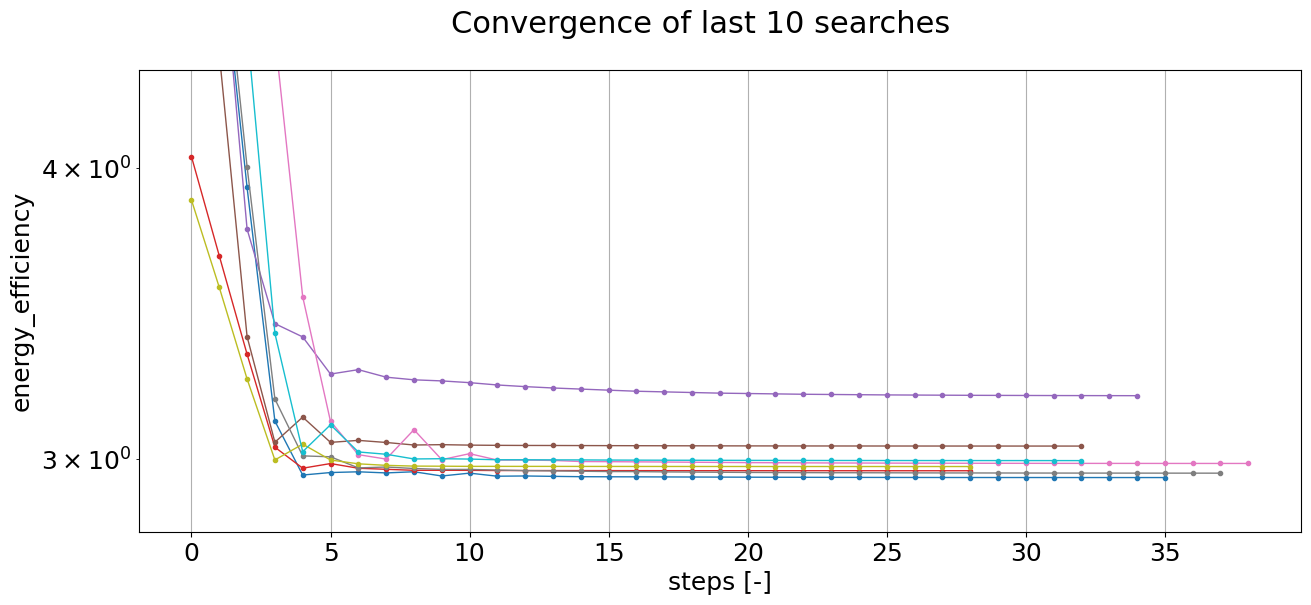

In [23]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(0.95*best_output, 1.5*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

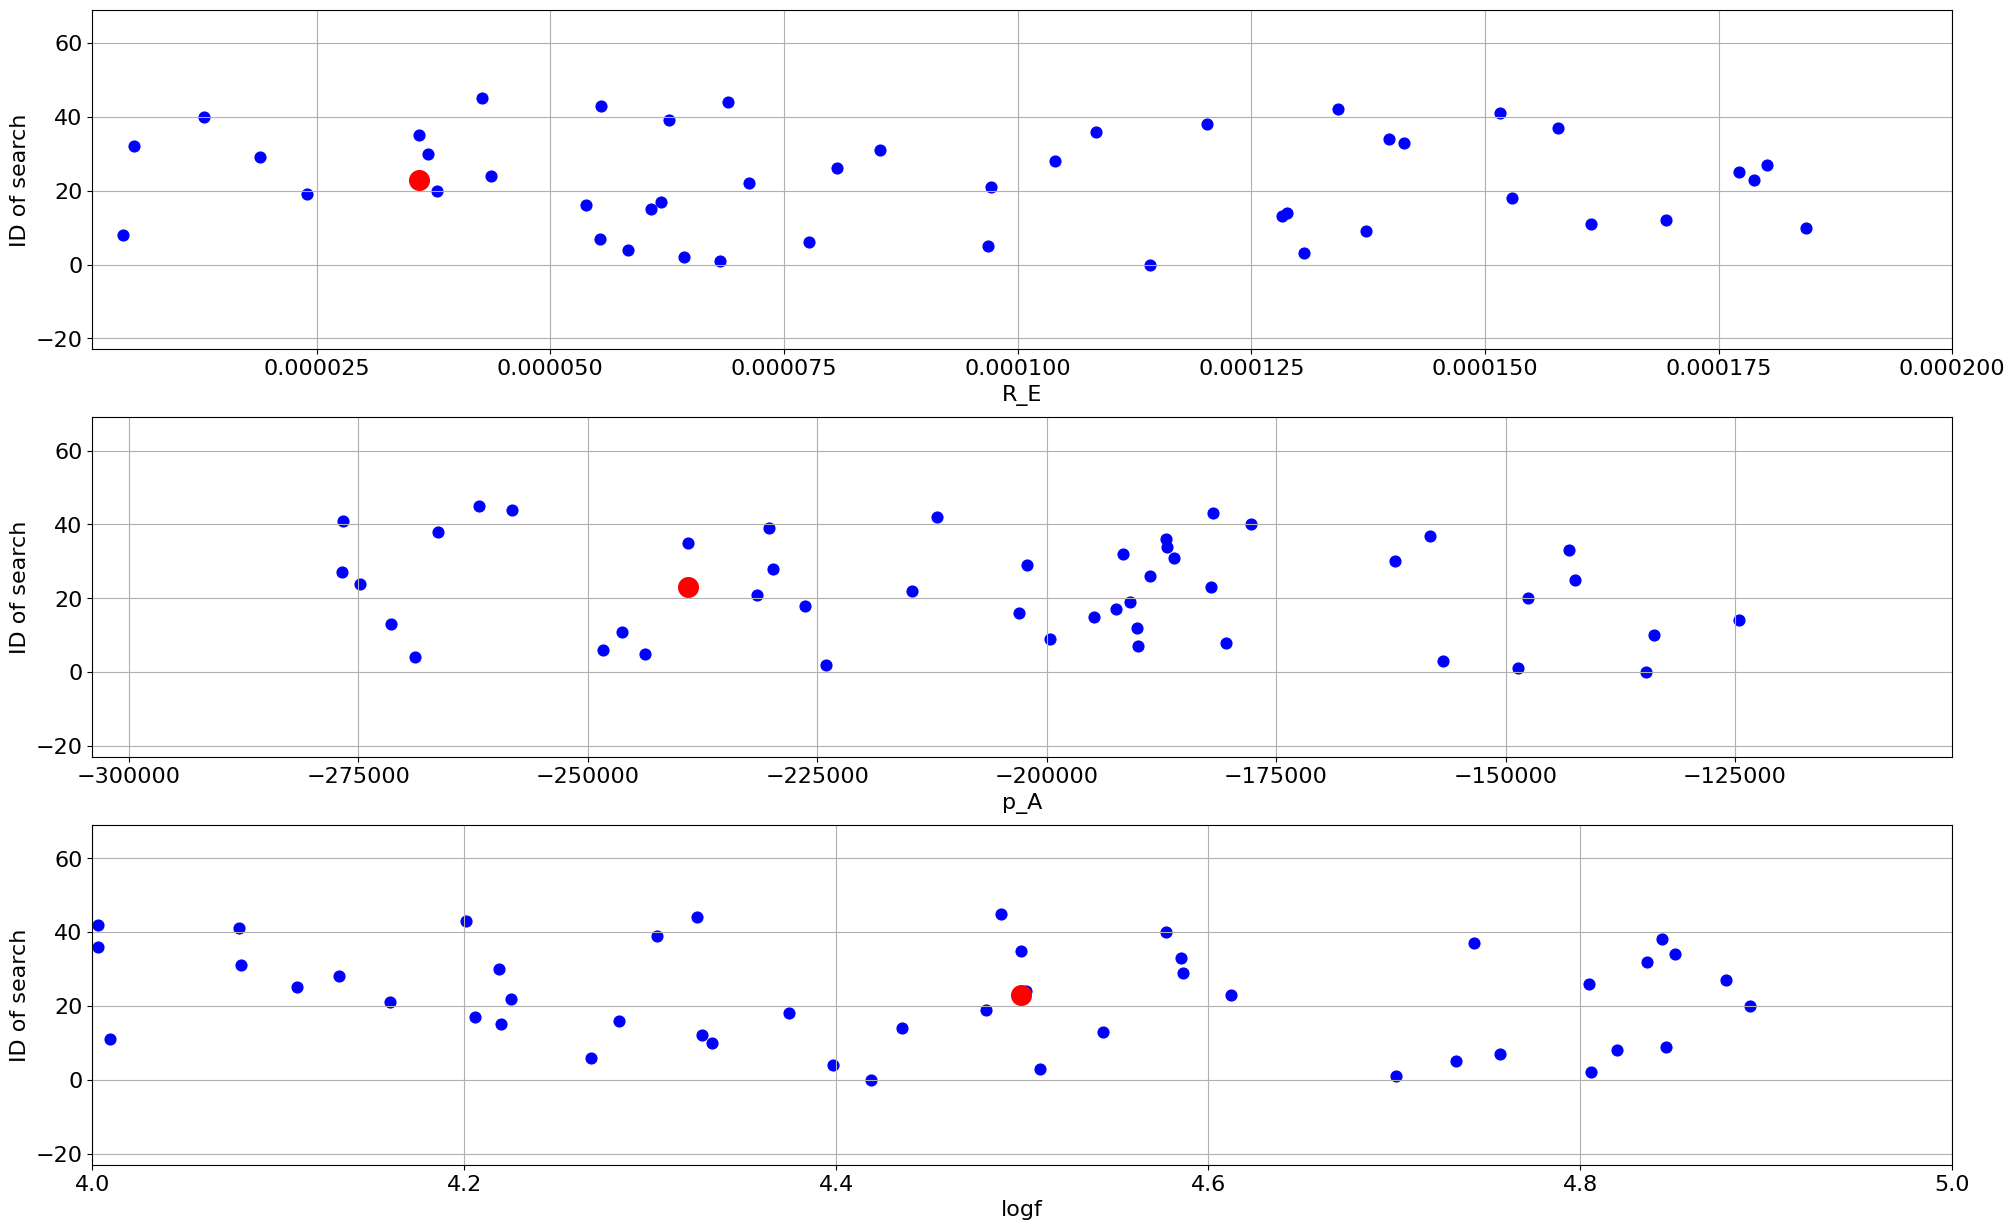

In [24]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.5*n, 1.5*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
